# Exploration

## Setup

In [79]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from itertools import product
import numpy as np

from sklearn.svm import SVC


## Visualisation / Data Loading

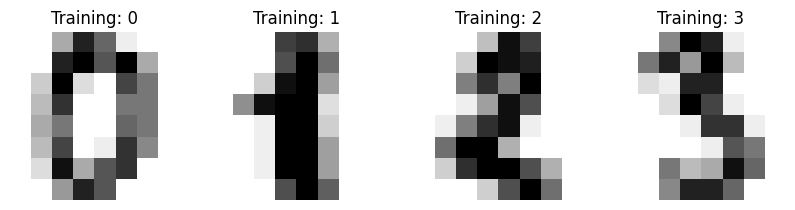

In [123]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [124]:
# Dataset plus difficile mais encore majoritairement linéairement séparable
X_toy, y_toy = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1,
                           class_sep=0.8, flip_y=0.05, random_state=42)

# Deux versions : données dans l'ordre vs données mélangées
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

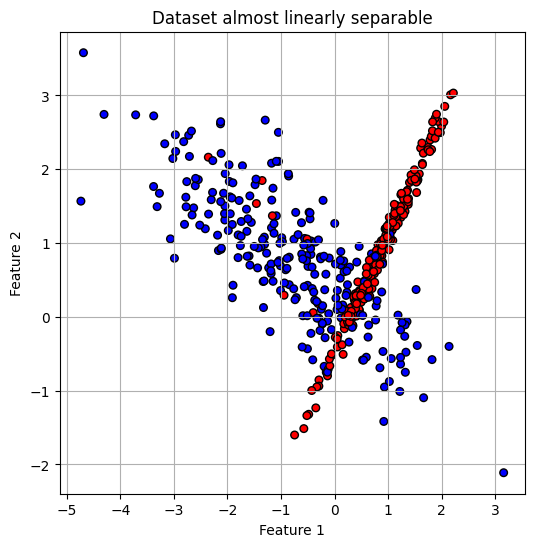

In [95]:
plt.figure(figsize=(6, 6))
plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, cmap='bwr', edgecolor='k', s=30)
plt.title("Dataset almost linearly separable")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

## SVM

In [28]:
# flatten the images
n_samples = len(digits.images)
digits_data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    digits_data, digits.target, test_size=0.5, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

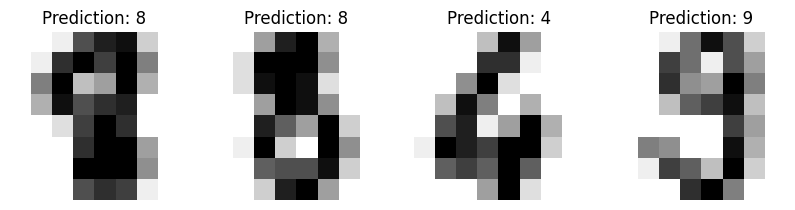

In [29]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

## Perceptron on Toy Dataset

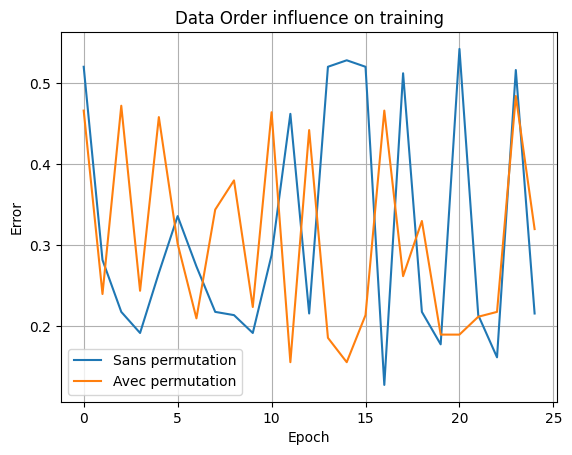

In [30]:
# 3. Initialise 2 identical perceptron
model_ordered = Perceptron(max_iter=1000, warm_start=True, random_state=42)
model_shuffled = Perceptron(max_iter=1000, warm_start=True, random_state=42)

n_epochs = 25
loss_ordered = []
loss_shuffled = []

def compute_error(model, X, y):
    return np.mean(model.predict(X) != y)

# 4. Train the 2 modèles epoch par epoch
for epoch in range(n_epochs):
    model_ordered.fit(X_toy, y_toy)
    model_shuffled.fit(X_shuffled, y_shuffled)
    
    loss_ordered.append(compute_error(model_ordered, X_toy, y_toy))
    loss_shuffled.append(compute_error(model_shuffled, X_toy, y_toy))

plt.plot(loss_ordered, label='Sans permutation')
plt.plot(loss_shuffled, label='Avec permutation')
plt.xlabel('Epoch')
plt.ylabel("Error")
plt.title("Data Order influence on training")
plt.legend()
plt.grid(True)
plt.show()

# Analyse

## Influence de l'ordre des données

### (1) Curriculum Learning

In [141]:
def plot_CL_results(difficulty_range, test_accuracies, train_accuracies, title):
    plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
    plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
    plt.xlabel("Percentage of training data (by difficulty)")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

#### Toy Dataset

##### Pre-analysis

As curriculum learning is based on giving samples in increasing difficulty level to the model, we first need to define a difficulty function. We will base ours on difference between the distance of each point to the line that goes through all the data points.

In [131]:
# Compute the best-fit algebric function
reg = LinearRegression()
reg.fit(X_toy[:, [0]], X_toy[:, 1])
a = reg.coef_[0]
b = reg.intercept_

def compute_toy_difficulty(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    dist = np.abs(a * x1 - x2 + b) / np.sqrt(a**2 + 1)
    return dist

##### Analysis with Logistic Regression

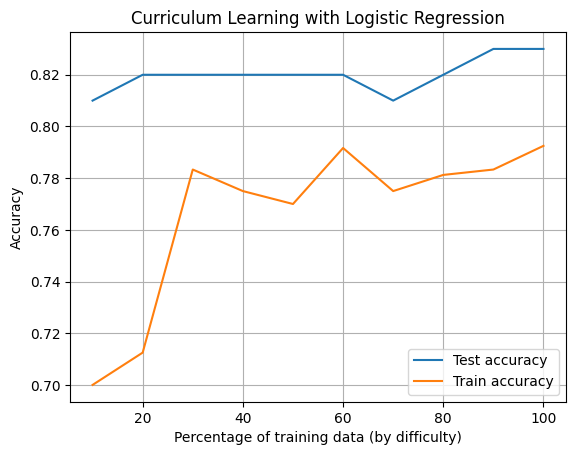

In [156]:
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(X_toy, y_toy, test_size=0.2, shuffle=True, random_state=42)

# Normalize the difficulty to [0, 1]
toy_difficulty = compute_toy_difficulty(X_train_toy)
norm_toy_difficulty = (toy_difficulty - toy_difficulty.min()) / (toy_difficulty.max() - toy_difficulty.min())
sorted_toy_indices = np.argsort(norm_toy_difficulty)

X_sorted = X_train_toy[sorted_toy_indices]
y_sorted = y_train_toy[sorted_toy_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
clf = LogisticRegression()

train_accuracies = []
test_accuracies = []

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_train_toy))
    X_train = X_train_toy[:n_samples]
    y_train = y_train_toy[:n_samples]
    
    clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test_toy, clf.predict(X_test_toy))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
plot_CL_results(difficulty_range, test_accuracies, train_accuracies, "Curriculum Learning with Logistic Regression")

#### MNIST Dataset

##### Pre-analysis

Once again, as curriculum learning is based on giving samples in increasing difficulty level to the model, we first need to define a difficulty function. We will base ours on the distance to the class centroid.

In [41]:
def compute_MNIST_difficulty(X, y, centroids):
    dist = np.linalg.norm(X - centroids[y], axis=1)
    return dist

In [146]:
# standardization
X_MNIST = StandardScaler().fit_transform(digits_data)
y_MNIST = digits.target

# Split into train and test
X_train_MNIST, X_test_MNIST, y_train_MNIST, y_test_MNIST = train_test_split(X_MNIST, y_MNIST, test_size=0.2, shuffle=True, random_state=42)

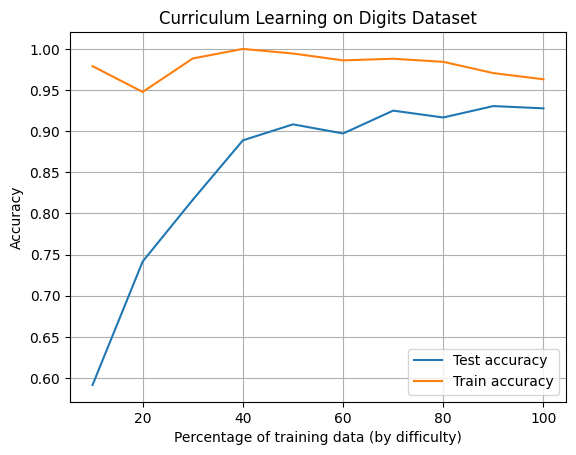

In [147]:
# compute class centroids to later apply the difficulty function
centroids = np.zeros((10, X_train_MNIST.shape[1]))
for digit in range(10):
    centroids[digit] = X_train_MNIST[y_train_MNIST == digit].mean(axis=0)

# normalize the difficulty to [0, 1]
MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST, y_train_MNIST, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# sort by difficulty
sorted_indices = np.argsort(norm_MNIST_difficulty)
X_sorted = X_train_MNIST[sorted_indices]
y_sorted = y_train_MNIST[sorted_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_sorted))
    X_curr = X_sorted[:n_samples]
    y_curr = y_sorted[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST, test_pred))

# Plot results
plot_CL_results(difficulty_range, test_accuracies, train_accuracies, "Curriculum Learning on Digits Dataset")

### (2) Self-Paced Learning

In Self-Paced Learning, the model is supposed to:
• learn from easier samples first (based on current loss)
• adaptively expand its training set to include harder samples as it becomes more confident

#### Toy Dataset

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_26943/409718408.py:45: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_26943/409718408.py:45: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_26943/409718408.py:45: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_26943/409718408.py:45: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_26943/409718408.py:45: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
/var/folde

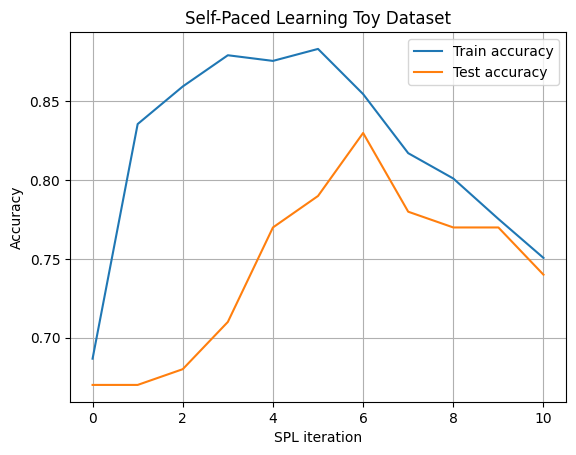

In [157]:
# Standardisation
scaler = StandardScaler()
X_train_toy = scaler.fit_transform(X_train_toy)
X_test_toy = scaler.transform(X_test_toy)

classes = np.unique(y_toy)

# Grille de paramètres SPL
lambda_t_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
lambda_growth_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
init_sizes = [50, 100, 150, 200, 250, 300]

max_iters = 10
results = {}

for lambda_t_init in lambda_t_values:
    for lambda_growth in lambda_growth_values:
        for init_size in init_sizes:
            np.random.seed(42)

            # Init SPL
            init_idx = np.random.choice(len(X_train), size=init_size, replace=False)
            X_curr = X_train[init_idx]
            y_curr = y_train[init_idx]

            mask = np.ones(len(X_train), dtype=bool)
            mask[init_idx] = False
            X_pool = X_train[mask]
            y_pool = y_train[mask]

            clf = SGDClassifier(loss="log_loss", random_state=42)
            clf.partial_fit(X_curr, y_curr, classes=classes)

            lambda_t = lambda_t_init
            train_accuracies = []
            test_accuracies = []

            # Accuracy
            init_acc = accuracy_score(y_test, clf.predict(X_test))
            test_accuracies.append(init_acc)
            train_accuracies.append(accuracy_score(y_curr, clf.predict(X_curr)))

            for it in range(max_iters):
                probas = clf.predict_proba(X_pool)
                sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
                easy_mask = sample_losses <= lambda_t

                if not np.any(easy_mask):
                    break

                X_easy = X_pool[easy_mask]
                y_easy = y_pool[easy_mask]

                X_curr = np.vstack([X_curr, X_easy])
                y_curr = np.concatenate([y_curr, y_easy])

                X_pool = X_pool[~easy_mask]
                y_pool = y_pool[~easy_mask]

                clf.partial_fit(X_easy, y_easy)

                train_acc = accuracy_score(y_curr, clf.predict(X_curr))
                test_acc = accuracy_score(y_test, clf.predict(X_test))

                train_accuracies.append(train_acc)
                test_accuracies.append(test_acc)

                lambda_t += lambda_growth

            test_accuracies = np.array(test_accuracies)
            acc_improvement = np.max(test_accuracies - init_acc)

            config = (lambda_t_init, lambda_growth, init_size)
            results[config] = {
                "train_acc": train_accuracies,
                "test_acc": test_accuracies,
                "init_acc": init_acc,
                "final_acc": test_accuracies[-1],
                "acc_improvement": acc_improvement
            }

# Trouver la config avec la meilleure amélioration
(_, data_best) = max(results.items(), key=lambda x: x[1]["acc_improvement"])


# Tracé
plt.plot(data_best["train_acc"], label="Train accuracy")
plt.plot(data_best["test_acc"], label="Test accuracy")
plt.title(f"Self-Paced Learning Toy Dataset")
plt.xlabel("SPL iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


#### MNIST Dataset

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

Let's determine the best combination of parameters.

In [150]:
def run_spl(X_train, y_train, X_test, y_test, classes, 
            lambda_t_init, lambda_growth, init_size, max_iters=10, random_state=42):
    np.random.seed(random_state)

    # Init training subset
    init_idx = np.random.choice(len(X_train), size=init_size, replace=False)
    X_curr = X_train[init_idx]
    y_curr = y_train[init_idx]

    # Remaining pool
    mask = np.ones(len(X_train), dtype=bool)
    mask[init_idx] = False
    X_masked = X_train[mask]
    y_masked = y_train[mask]

    # Initial model
    clf = SGDClassifier(loss="log_loss", random_state=random_state)
    clf.partial_fit(X_curr, y_curr, classes=classes)

    lambda_t = lambda_t_init
    test_accuracies = []
    init_acc = None

    for it in range(1, max_iters + 1):
        probas = clf.predict_proba(X_masked)
        epsilon = 1e-12
        correct_class_probs = probas[np.arange(len(y_masked)), y_masked]
        sample_losses = -np.log(np.maximum(correct_class_probs, epsilon))
        
        filter_mask = sample_losses <= lambda_t
        if not np.any(filter_mask):
            break

        X_filtered = X_masked[filter_mask]
        y_filtered = y_masked[filter_mask]

        # Update train and pool
        X_curr = np.vstack([X_curr, X_filtered])
        y_curr = np.concatenate([y_curr, y_filtered])
        X_masked = X_masked[~filter_mask]
        y_masked = y_masked[~filter_mask]

        clf.partial_fit(X_filtered, y_filtered)

        test_acc = accuracy_score(y_test, clf.predict(X_test))
        test_accuracies.append(test_acc)

        if it == 1:
            init_acc = test_acc  # Store initial test accuracy

        lambda_t += lambda_growth

    # Improvement over the first iteration
    test_accuracies = np.array(test_accuracies)
    acc_improvement = np.max(test_accuracies - init_acc) if init_acc is not None else 0.0

    return acc_improvement, test_accuracies



# Grid search parameters
lambda_t_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
lambda_growth_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
init_sizes = [50, 100, 150, 200, 250, 300]

best_score = 0
best_params = None
results = []

for lambda_t_init, lambda_growth, init_size in product(lambda_t_values, lambda_growth_values, init_sizes):
    score, acc_list = run_spl(X_train_MNIST, y_train_MNIST, X_test_MNIST, y_test_MNIST,
                              classes=np.unique(y_train_MNIST),
                              lambda_t_init=lambda_t_init,
                              lambda_growth=lambda_growth,
                              init_size=init_size)
    
    results.append(((lambda_t_init, lambda_growth, init_size), score))
    
    if score > best_score:
        best_params = (lambda_t_init, lambda_growth, init_size)

# Print best combination
print(f"Best params: lambda_t={best_params[0]}, lambda_growth={best_params[1]}, init_size={best_params[2]}")

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Best params: lambda_t=0.5, lambda_growth=0.3, init_size=250


/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_26943/411444848.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_26943/411444848.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_26943/411444848.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_26943/411444848.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_26943/411444848.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y

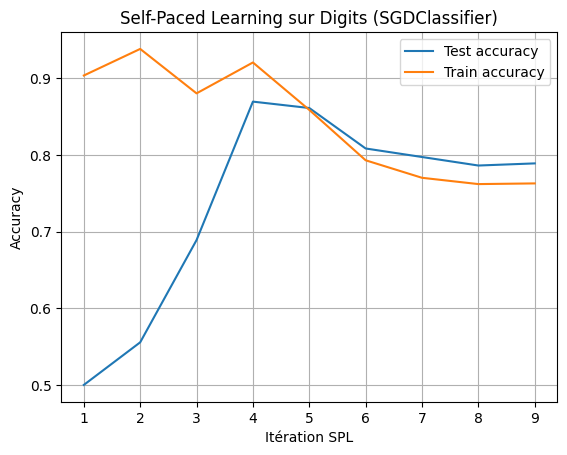

In [158]:
classes = np.unique(y_train_MNIST)

# definition learning parameters
# lambda t : init threshold corresponding to the maximum loss (which then determines difficulty)
# lambda growth : incrementation at every step
# the model is then able to decide how many samples of such difficilty it can handle
max_iters = 10
lambda_t = 0.25
lambda_growth = 0.3

# init training on small random subset
init_size = 50
init_idx = np.random.choice(len(X_train_MNIST), size=init_size, replace=False)
X_curr = X_train_MNIST[init_idx]
y_curr = y_train_MNIST[init_idx]

# remaining pool
mask = np.ones(len(X_train_MNIST), dtype=bool)
mask[init_idx] = False
X_masked = X_train_MNIST[mask]
y_masked = y_train_MNIST[mask]

# initial fit
clf = SGDClassifier(loss="log_loss", random_state=42)
clf.partial_fit(X_curr, y_curr, classes=classes)

train_accuracies = []
test_accuracies = []

for it in range(1, max_iters + 1):
    # calculation probs & loss per sample
    probas = clf.predict_proba(X_masked)
    sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])

    filter_mask = sample_losses <= lambda_t
    if not np.any(filter_mask):
        break

    X_filtered = X_masked[filter_mask]
    y_filtered = y_masked[filter_mask]

    X_curr = np.vstack([X_curr, X_filtered])
    y_curr = np.concatenate([y_curr, y_filtered])

    X_masked = X_masked[~filter_mask]
    y_masked = y_masked[~filter_mask]

    clf.partial_fit(X_filtered, y_filtered)

    train_acc = accuracy_score(y_curr, clf.predict(X_curr))
    test_acc = accuracy_score(y_test_MNIST, clf.predict(X_test_MNIST))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    lambda_t += lambda_growth

# tracé des courbes d'apprentissage
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label="Test accuracy")
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train accuracy")
plt.xlabel("Itération SPL")
plt.ylabel("Accuracy")
plt.title("Self-Paced Learning sur Digits (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (3) Hard-Example Mining

Hard-Example Mining consists in feeding the model only hard examples. In our case, we will consider that a sample is difficult if its normalized difficulty is greater or equal than 0,75 (in other words the top 25%).

#### Toy Dataset

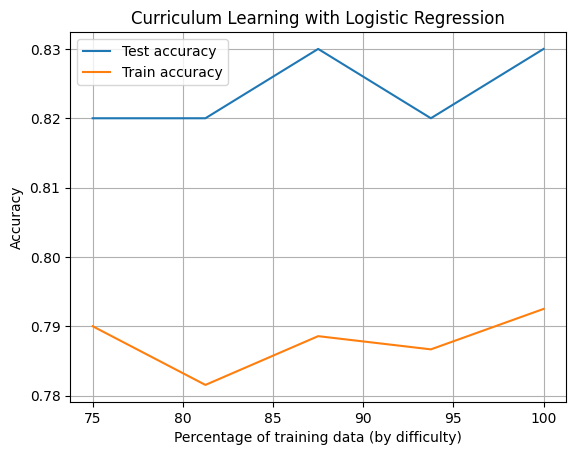

In [159]:
sorted_indices = np.argsort(norm_toy_difficulty)

X_sorted = X_train_toy[sorted_indices]
y_sorted = y_train_toy[sorted_indices]

# Curriculum training: increase % of training data
percentages = np.linspace(0.75, 1, 5)
train_accuracies = []
test_accuracies = []


for percentage in percentages:
    n_samples = int(percentage * len(X_train_toy))
    X_train = X_train_toy[:n_samples]
    y_train = y_train_toy[:n_samples]
    
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test_toy, clf.predict(X_test_toy))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
# Plot
plt.plot(percentages * 100, test_accuracies, label="Test accuracy")
plt.plot(percentages * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Curriculum Learning with Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

#### MNIST Dataset

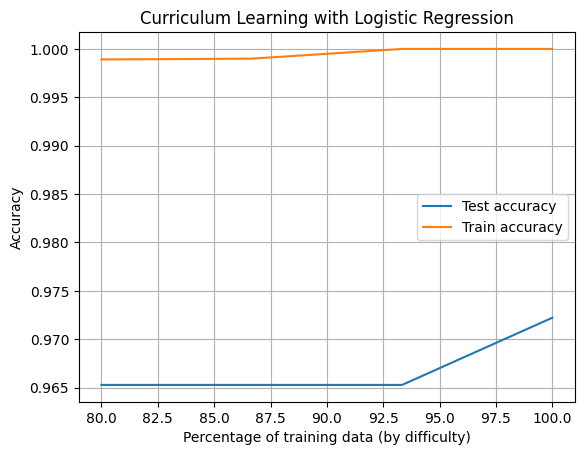

In [160]:
sorted_indices = np.argsort(norm_MNIST_difficulty)
X_sorted = X_MNIST[sorted_indices]
y_sorted = y_MNIST[sorted_indices]

# Curriculum training: increase % of training data
percentages = np.linspace(0.8, 1, 4)
train_accuracies = []
test_accuracies = []

# test set
X_train_all, X_test_MNIST, y_train_all, y_test_MNIST = train_test_split(X_sorted, y_sorted, test_size=0.2, random_state=42)

for percentage in percentages:
    n_samples = int(percentage * len(X_train_all))
    X_train_MNIST = X_train_all[:n_samples]
    y_train_MNIST = y_train_all[:n_samples]
    
    clf = LogisticRegression()
    clf.fit(X_train_MNIST, y_train_MNIST)
    
    train_acc = accuracy_score(y_train_MNIST, clf.predict(X_train_MNIST))
    test_acc = accuracy_score(y_test_MNIST, clf.predict(X_test_MNIST))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
# Plot
plt.plot(percentages * 100, test_accuracies, label="Test accuracy")
plt.plot(percentages * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Curriculum Learning with Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

### (4) Reverse Curriculum Learning

### (5) Échantillonnage Monte-Carlo stratifié

## Randomization des données

### (1) Ordre Naturel

### (2) One-Time Shuffling

### (3) Multiple Shuffling